/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Starting training...


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

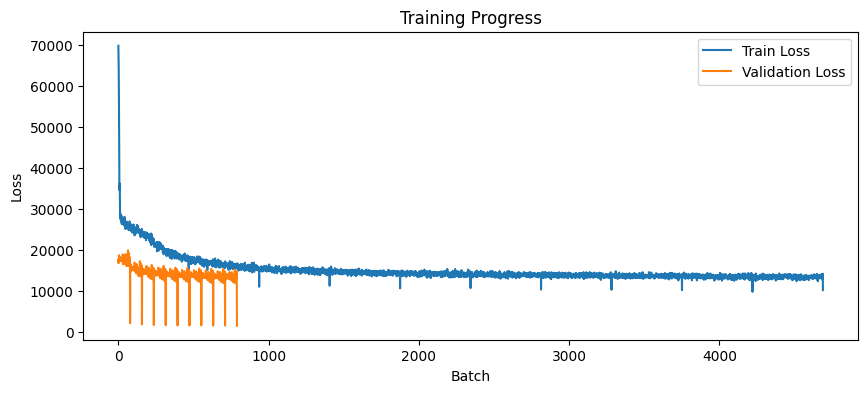

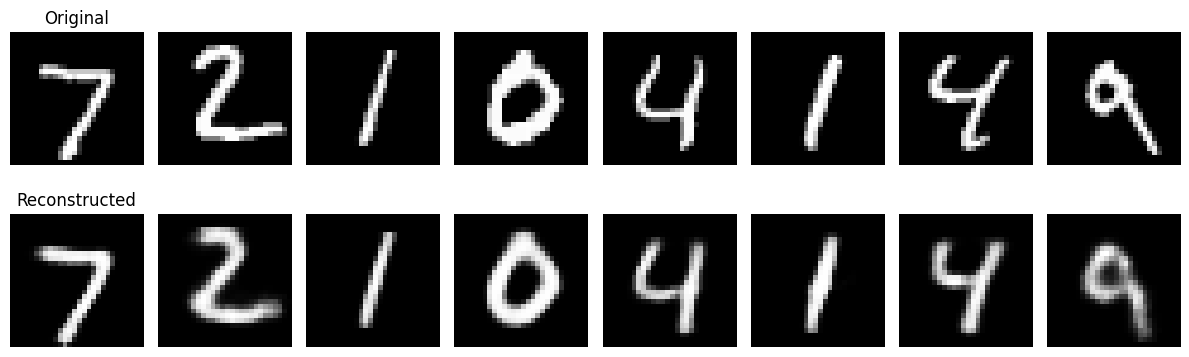

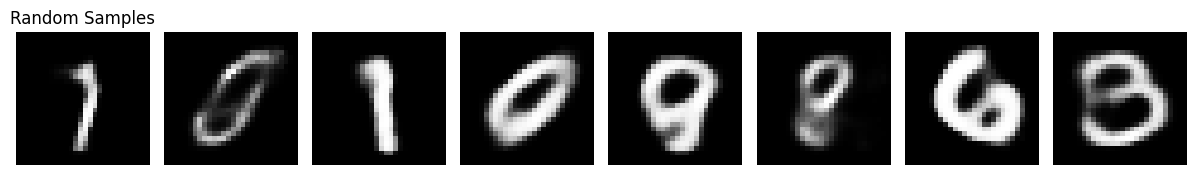

In [2]:
# Install required packages
!pip install pytorch-lightning tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import pytorch_lightning as pl
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np

class VAE(pl.LightningModule):
    def __init__(self, 
                 input_dim: int = 784,
                 hidden_dim: int = 400,
                 latent_dim: int = 20,
                 learning_rate: float = 1e-3):
        super().__init__()
        
        self.save_hyperparameters()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        
        # Latent space projections
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_var = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )
        
        self.learning_rate = learning_rate
        
        # For tracking metrics
        self.train_losses = []
        self.val_losses = []
        
    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
        
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, log_var = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var
    
    def training_step(self, batch, batch_idx):
        x, _ = batch
        x = x.view(-1, 784)
        
        # Forward pass
        recon_x, mu, log_var = self(x)
        
        # Reconstruction loss
        recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
        
        # KL divergence loss
        kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        # Total loss
        loss = recon_loss + kl_loss
        
        # Store loss for plotting
        self.train_losses.append(loss.item())
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, _ = batch
        x = x.view(-1, 784)
        
        recon_x, mu, log_var = self(x)
        
        recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
        kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        loss = recon_loss + kl_loss
        
        self.val_losses.append(loss.item())
        
        # Save example reconstructions
        if batch_idx == 0:
            self.example_input = x[:8]
            self.example_recon = recon_x[:8]
        
        return loss
    
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.learning_rate)

def plot_training_progress(train_losses, val_losses):
    plt.figure(figsize=(10, 4))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.title('Training Progress')
    plt.legend()
    plt.show()

def plot_reconstructions(model, example_input, example_recon):
    plt.figure(figsize=(12, 4))
    
    # Plot original images
    for i in range(8):
        plt.subplot(2, 8, i + 1)
        plt.imshow(example_input[i].cpu().view(28, 28), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Original')
    
    # Plot reconstructions
    for i in range(8):
        plt.subplot(2, 8, i + 9)
        plt.imshow(example_recon[i].cpu().detach().view(28, 28), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Reconstructed')
            
    plt.tight_layout()
    plt.show()

def plot_random_samples(model, num_samples=8):
    with torch.no_grad():
        # Sample from standard normal distribution
        z = torch.randn(num_samples, model.hparams.latent_dim).to(model.device)
        # Decode the latent vectors
        samples = model.decode(z)
    
    plt.figure(figsize=(12, 2))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(samples[i].cpu().view(28, 28), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Random Samples')
    
    plt.tight_layout()
    plt.show()

# Training setup
def train_vae():
    # Set random seeds for reproducibility
    pl.seed_everything(42)
    
    # Data transformations
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    
    # Load MNIST dataset
    train_dataset = datasets.MNIST('/kaggle/working/data', train=True, download=True, transform=transform)
    val_dataset = datasets.MNIST('/kaggle/working/data', train=False, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=128, num_workers=2)
    
    # Initialize model
    model = VAE()
    
    # Initialize trainer
    trainer = pl.Trainer(
        max_epochs=10,  # Reduced for demonstration
        accelerator='auto',
        devices=1,
        enable_progress_bar=True,
        num_sanity_val_steps=0
    )
    
    # Train model
    trainer.fit(model, train_loader, val_loader)
    
    return model, train_loader, val_loader

# Run training
print("Starting training...")
model_MLP, train_loader, val_loader = train_vae()

# Plot results
plot_training_progress(model_MLP.train_losses, model_MLP.val_losses)
plot_reconstructions(model_MLP, model_MLP.example_input, model_MLP.example_recon)
plot_random_samples(model_MLP)

Training CNN VAE...


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

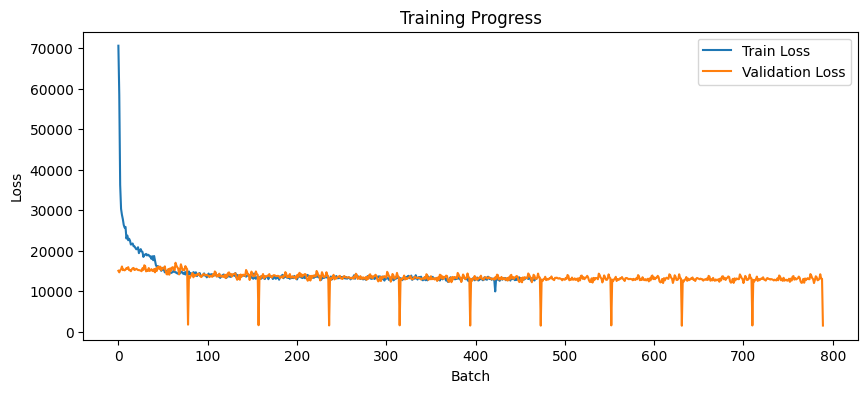

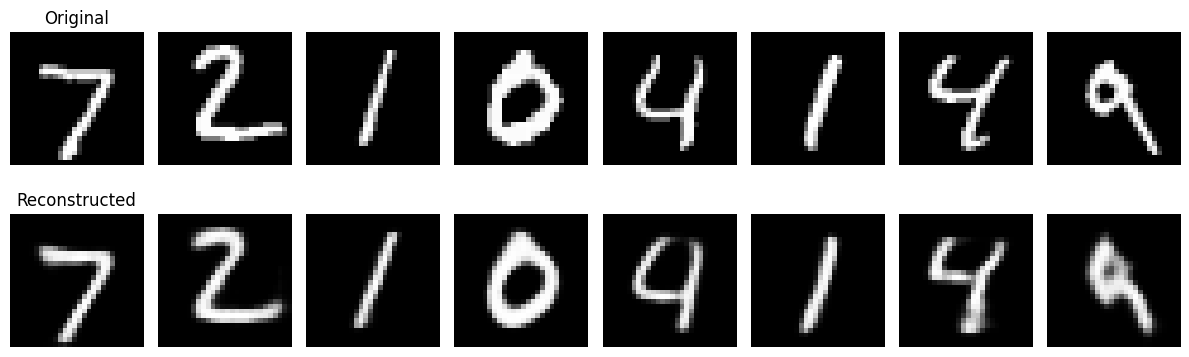

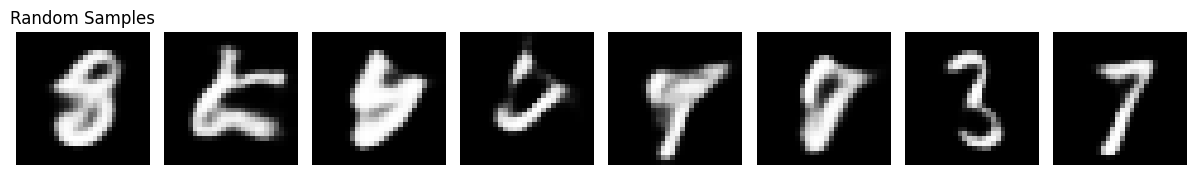

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import pytorch_lightning as pl
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np

class CNNVAE(pl.LightningModule):
    """Convolutional VAE implementation"""
    def __init__(self, 
                 latent_dim: int = 20,
                 learning_rate: float = 1e-3):
        super().__init__()
        self.save_hyperparameters()
        
        # Initialize buffers for storing examples
        self.register_buffer('example_input', None)
        self.register_buffer('example_recon', None)
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # 14x14
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 7x7
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),  # 7x7
            nn.ReLU(),
        )
        
        # Flatten layer
        self.flatten = nn.Flatten()
        
        # Latent space projections
        self.fc_mu = nn.Linear(64 * 7 * 7, latent_dim)
        self.fc_var = nn.Linear(64 * 7 * 7, latent_dim)
        
        # Decoder layers
        self.decoder_input = nn.Linear(latent_dim, 64 * 7 * 7)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # 28x28
            nn.ReLU(),
            nn.Conv2d(16, 1, kernel_size=3, stride=1, padding=1),  # 28x28
            nn.Sigmoid()
        )
        
        self.learning_rate = learning_rate
        self.train_losses = []
        self.val_losses = []
        
    def encode(self, x):
        x = self.encoder(x)
        x = self.flatten(x)
        return self.fc_mu(x), self.fc_var(x)
    
    def decode(self, z):
        x = self.decoder_input(z)
        x = x.view(-1, 64, 7, 7)
        return self.decoder(x)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var
    
    def _shared_step(self, batch, batch_idx, step_type='train'):
        x, _ = batch
        
        # Forward pass
        recon_x, mu, log_var = self(x)
        
        # Reconstruction loss
        recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
        
        # KL divergence loss
        kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        # Total loss
        loss = recon_loss + kl_loss
        
        # Store losses and examples
        if step_type == 'train':
            self.train_losses.append(loss.item())
        else:
            self.val_losses.append(loss.item())
            if batch_idx == 0:
                self.example_input = x[:8]
                self.example_recon = recon_x[:8]
        
        if batch_idx % 100 == 0:
            self.log(f'{step_type}_loss', loss)
        
        return loss
    
    def training_step(self, batch, batch_idx):
        return self._shared_step(batch, batch_idx, 'train')
        
    def validation_step(self, batch, batch_idx):
        return self._shared_step(batch, batch_idx, 'val')
    
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.learning_rate)

def plot_training_progress(model):
    plt.figure(figsize=(10, 4))
    plt.plot(model.train_losses[::10], label='Train Loss')  # Plot every 10th point
    plt.plot(model.val_losses, label='Validation Loss')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.title('Training Progress')
    plt.legend()
    plt.show()

def plot_reconstructions(model):
    plt.figure(figsize=(12, 4))
    
    # Plot original images
    for i in range(8):
        plt.subplot(2, 8, i + 1)
        plt.imshow(model.example_input[i].cpu().squeeze(), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Original')
    
    # Plot reconstructions
    for i in range(8):
        plt.subplot(2, 8, i + 9)
        plt.imshow(model.example_recon[i].cpu().detach().squeeze(), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Reconstructed')
            
    plt.tight_layout()
    plt.show()

def plot_random_samples(model, num_samples=8):
    with torch.no_grad():
        # Sample from standard normal distribution
        z = torch.randn(num_samples, model.hparams.latent_dim).to(model.device)
        # Decode the latent vectors
        samples = model.decode(z)
    
    plt.figure(figsize=(12, 2))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(samples[i].cpu().squeeze(), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Random Samples')
    
    plt.tight_layout()
    plt.show()

def train_cnn_vae():
    """Function to train the CNN VAE"""
    # Set random seeds for reproducibility
    pl.seed_everything(42)
    
    # Data transformations
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    
    # Load MNIST dataset
    train_dataset = datasets.MNIST('/kaggle/working/data', train=True, download=True, transform=transform)
    val_dataset = datasets.MNIST('/kaggle/working/data', train=False, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=128, num_workers=2)
    
    # Initialize model
    model = CNNVAE()
    
    # Initialize trainer
    trainer = pl.Trainer(
        max_epochs=10,
        accelerator='auto',
        devices=1,
        enable_progress_bar=True,
        num_sanity_val_steps=0
    )
    
    # Train model
    print("Training CNN VAE...")
    trainer.fit(model, train_loader, val_loader)
    
    # Plot results
    plot_training_progress(model)
    plot_reconstructions(model)
    plot_random_samples(model)
    
    return model, train_loader, val_loader

if __name__ == "__main__":
    model_CNN, train_loader, val_loader = train_cnn_vae()

Running comprehensive comparison between MLP and CNN VAEs...

1. Plotting training progress comparison...


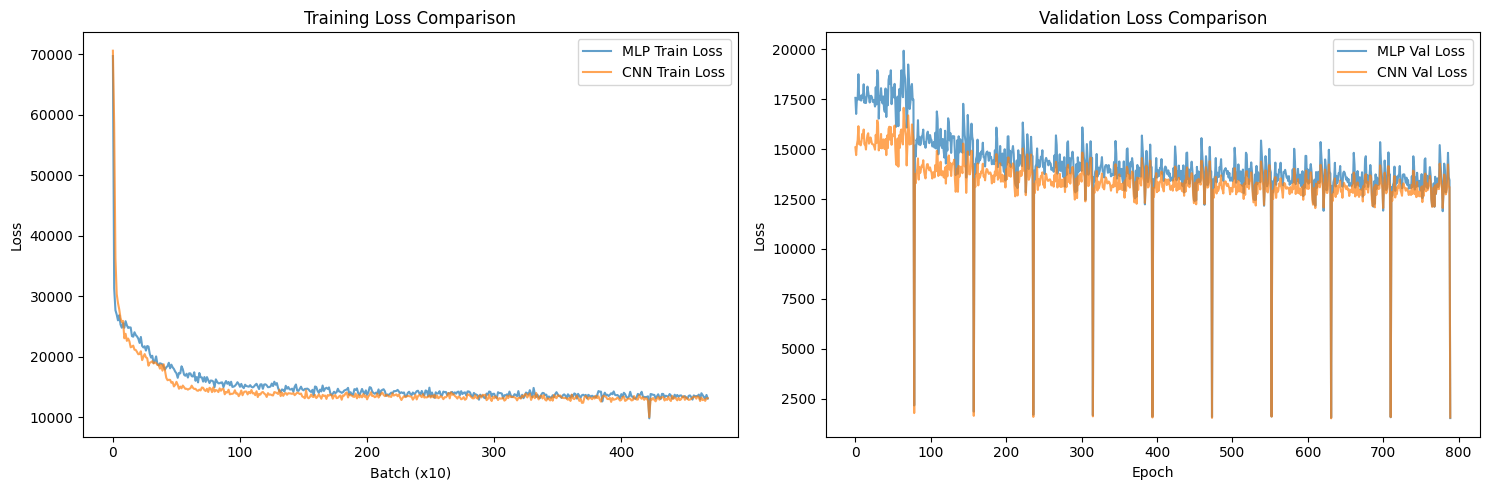


2. Plotting reconstruction comparison...


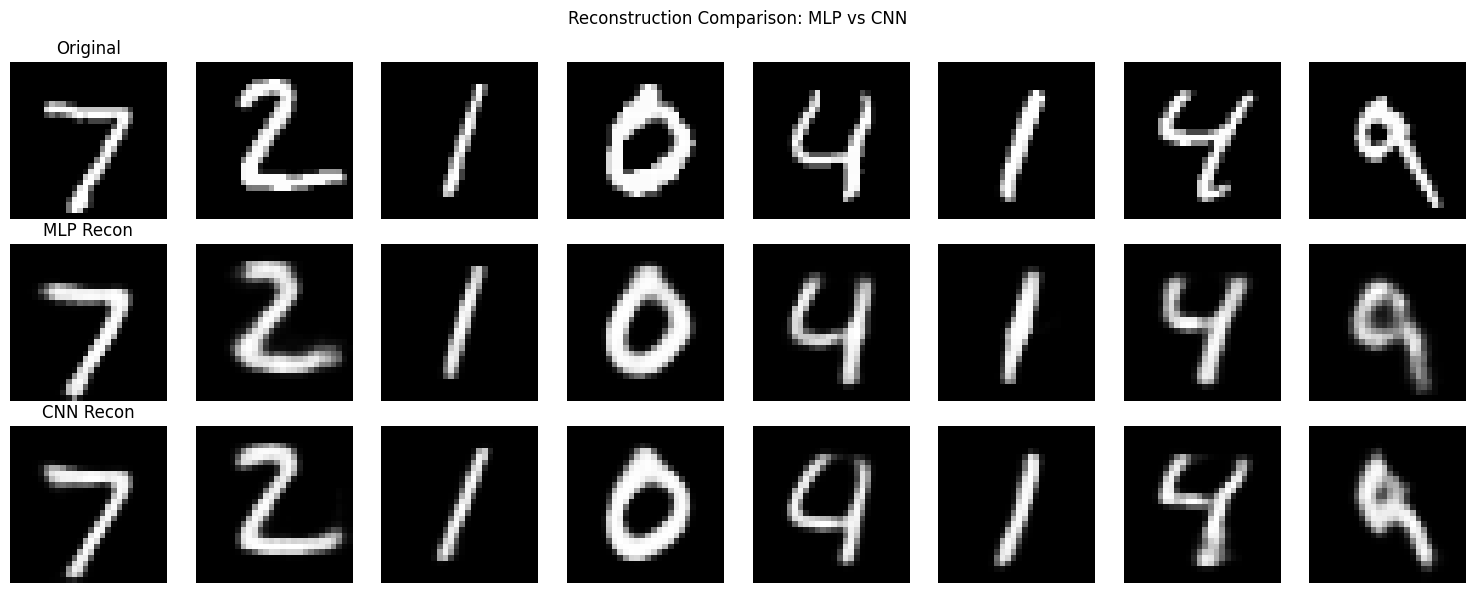


3. Plotting random samples comparison...


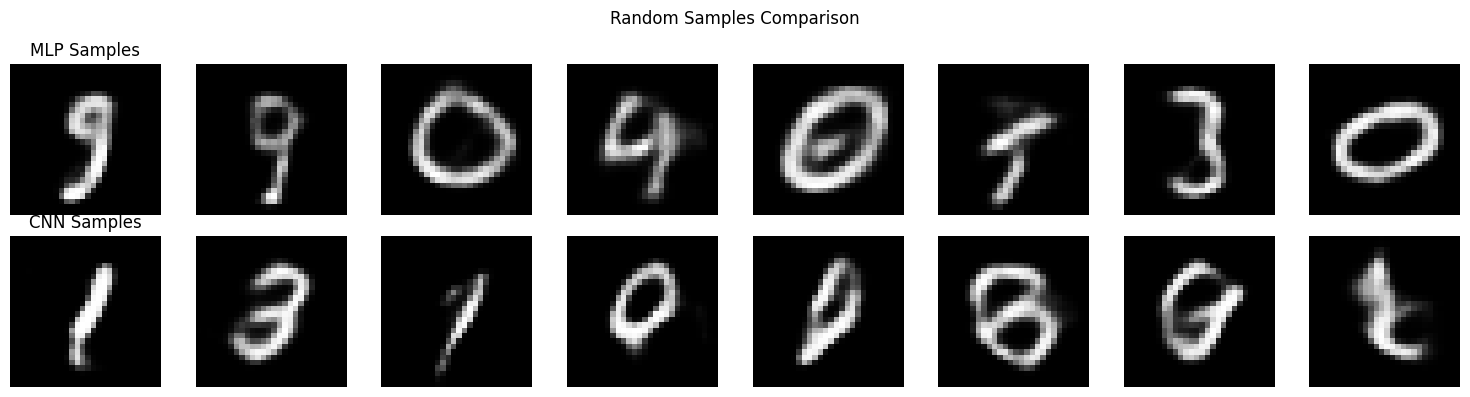


4. Plotting latent space interpolation comparison...


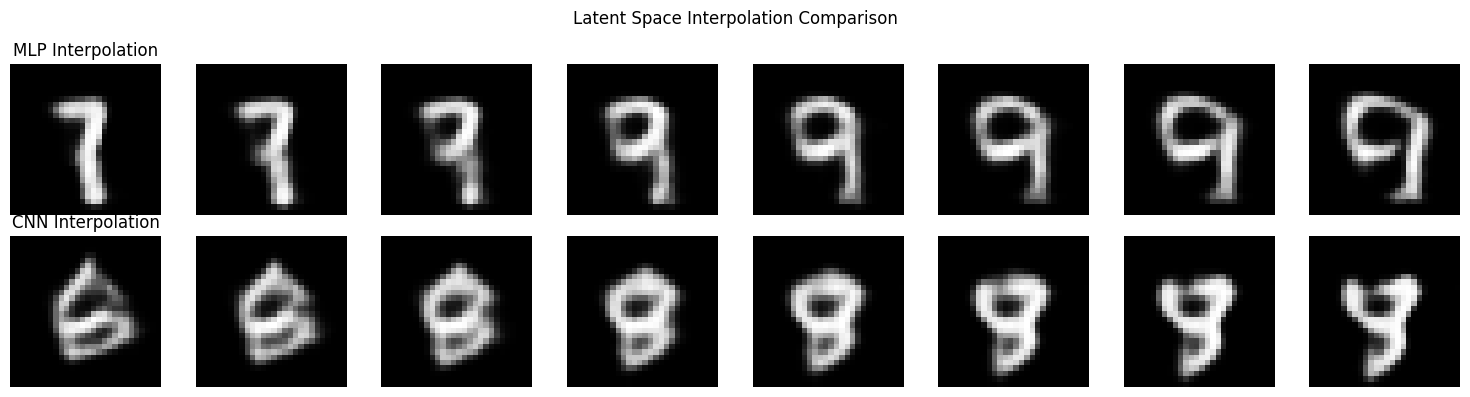


5. Computing comparison metrics...

Model Comparison Summary
--------------------------------------------------

MLP VAE:
Reconstruction MSE: 12.561549
Total Parameters: 973,624

CNN VAE:
Reconstruction MSE: 9.494766
Total Parameters: 270,313

Comparison:
CNN improves reconstruction MSE by 24.4%
CNN parameters ratio to MLP: 0.28x


In [4]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

def plot_loss_comparison(model_mlp, model_cnn):
    """Plot training progress comparison between MLP and CNN VAEs"""
    plt.figure(figsize=(15, 5))
    
    # Training loss
    plt.subplot(1, 2, 1)
    plt.plot(model_mlp.train_losses[::10], label='MLP Train Loss', alpha=0.7)
    plt.plot(model_cnn.train_losses[::10], label='CNN Train Loss', alpha=0.7)
    plt.xlabel('Batch (x10)')
    plt.ylabel('Loss')
    plt.title('Training Loss Comparison')
    plt.legend()
    
    # Validation loss
    plt.subplot(1, 2, 2)
    plt.plot(model_mlp.val_losses, label='MLP Val Loss', alpha=0.7)
    plt.plot(model_cnn.val_losses, label='CNN Val Loss', alpha=0.7)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Validation Loss Comparison')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def plot_reconstruction_comparison(model_mlp, model_cnn):
    """Plot reconstruction comparison between MLP and CNN VAEs"""
    plt.figure(figsize=(15, 6))
    
    # Original images
    for i in range(8):
        plt.subplot(3, 8, i + 1)
        plt.imshow(model_mlp.example_input[i].cpu().view(28, 28), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Original')
    
    # MLP reconstructions
    for i in range(8):
        plt.subplot(3, 8, i + 9)
        plt.imshow(model_mlp.example_recon[i].cpu().detach().view(28, 28), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('MLP Recon')
    
    # CNN reconstructions
    for i in range(8):
        plt.subplot(3, 8, i + 17)
        plt.imshow(model_cnn.example_recon[i].cpu().detach().squeeze(), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('CNN Recon')
            
    plt.suptitle('Reconstruction Comparison: MLP vs CNN')
    plt.tight_layout()
    plt.show()

def plot_random_samples_comparison(model_mlp, model_cnn, num_samples=8):
    """Plot random samples comparison between MLP and CNN VAEs"""
    plt.figure(figsize=(15, 4))
    
    # Generate MLP samples
    with torch.no_grad():
        z = torch.randn(num_samples, model_mlp.hparams.latent_dim).to(model_mlp.device)
        samples_mlp = model_mlp.decode(z)
    
    # Generate CNN samples
    with torch.no_grad():
        z = torch.randn(num_samples, model_cnn.hparams.latent_dim).to(model_cnn.device)
        samples_cnn = model_cnn.decode(z)
    
    # Plot MLP samples
    for i in range(num_samples):
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(samples_mlp[i].cpu().view(28, 28), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('MLP Samples')
    
    # Plot CNN samples
    for i in range(num_samples):
        plt.subplot(2, num_samples, i + num_samples + 1)
        plt.imshow(samples_cnn[i].cpu().squeeze(), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('CNN Samples')
    
    plt.suptitle('Random Samples Comparison')
    plt.tight_layout()
    plt.show()

def plot_latent_interpolation(model_mlp, model_cnn, num_steps=8):
    """Plot latent space interpolation comparison"""
    plt.figure(figsize=(15, 4))
    
    # Generate two random points in latent space
    z1 = torch.randn(1, model_mlp.hparams.latent_dim).to(model_mlp.device)
    z2 = torch.randn(1, model_mlp.hparams.latent_dim).to(model_mlp.device)
    
    # Create interpolation steps
    alphas = torch.linspace(0, 1, num_steps)
    interp_points = torch.stack([(1-a)*z1 + a*z2 for a in alphas]).squeeze()
    
    # Generate interpolated images for MLP
    with torch.no_grad():
        samples_mlp = model_mlp.decode(interp_points).view(-1, 1, 28, 28)
    
    # Generate interpolated images for CNN
    with torch.no_grad():
        samples_cnn = model_cnn.decode(interp_points)
    
    # Plot MLP interpolation
    for i in range(num_steps):
        plt.subplot(2, num_steps, i + 1)
        plt.imshow(samples_mlp[i].cpu().squeeze(), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('MLP Interpolation')
    
    # Plot CNN interpolation
    for i in range(num_steps):
        plt.subplot(2, num_steps, i + num_steps + 1)
        plt.imshow(samples_cnn[i].cpu().squeeze(), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('CNN Interpolation')
    
    plt.suptitle('Latent Space Interpolation Comparison')
    plt.tight_layout()
    plt.show()

def compute_metrics(model_mlp, model_cnn, val_loader):
    """Compute and compare metrics between MLP and CNN VAEs"""
    models = {'MLP': model_mlp, 'CNN': model_cnn}
    metrics = {}
    
    for name, model in models.items():
        model.eval()
        total_mse = 0
        total_samples = 0
        
        with torch.no_grad():
            for batch in val_loader:
                x, _ = batch
                x = x.to(model.device)
                
                if name == 'MLP':
                    x_flat = x.view(-1, 784)
                    recon_x, _, _ = model(x_flat)
                    recon_x = recon_x.view(-1, 1, 28, 28)
                else:
                    recon_x, _, _ = model(x)
                
                mse = F.mse_loss(recon_x, x, reduction='sum')
                total_mse += mse.item()
                total_samples += x.size(0)
        
        avg_mse = total_mse / total_samples
        metrics[name] = {
            'MSE': avg_mse,
            'Parameters': sum(p.numel() for p in model.parameters())
        }
    
    return metrics

def print_comparison_summary(metrics):
    """Print summary of model comparisons"""
    print("\nModel Comparison Summary")
    print("-" * 50)
    
    for model_name, model_metrics in metrics.items():
        print(f"\n{model_name} VAE:")
        print(f"Reconstruction MSE: {model_metrics['MSE']:.6f}")
        print(f"Total Parameters: {model_metrics['Parameters']:,}")
    
    # Compute relative improvements
    mse_improvement = (metrics['MLP']['MSE'] - metrics['CNN']['MSE']) / metrics['MLP']['MSE'] * 100
    param_ratio = metrics['CNN']['Parameters'] / metrics['MLP']['Parameters']
    
    print("\nComparison:")
    print(f"CNN improves reconstruction MSE by {mse_improvement:.1f}%")
    print(f"CNN parameters ratio to MLP: {param_ratio:.2f}x")

def run_comparison(model_mlp, model_cnn, val_loader):
    """Run complete comparison suite"""
    print("Running comprehensive comparison between MLP and CNN VAEs...")
    
    # Plot training progress
    print("\n1. Plotting training progress comparison...")
    plot_loss_comparison(model_mlp, model_cnn)
    
    # Plot reconstructions
    print("\n2. Plotting reconstruction comparison...")
    plot_reconstruction_comparison(model_mlp, model_cnn)
    
    # Plot random samples
    print("\n3. Plotting random samples comparison...")
    plot_random_samples_comparison(model_mlp, model_cnn)
    
    # Plot latent interpolation
    print("\n4. Plotting latent space interpolation comparison...")
    plot_latent_interpolation(model_mlp, model_cnn)
    
    # Compute and print metrics
    print("\n5. Computing comparison metrics...")
    metrics = compute_metrics(model_mlp, model_cnn, val_loader)
    print_comparison_summary(metrics)

if __name__ == "__main__":
    
    # Create validation loader for metrics
    val_dataset = datasets.MNIST('/kaggle/working/data', train=False, 
                               transform=transforms.ToTensor())
    val_loader = DataLoader(val_dataset, batch_size=128, num_workers=2)
    
    # Run comparison
    run_comparison(model_MLP, model_CNN, val_loader)